In [1]:
import numpy
import time
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import json

class TSdataset:

    def __init__(self, path:str, source:str):
        self.source = source
        self._features = {}
        self.MinMaxs = MinMaxScaler()
        if source =="NAB":
            split_name = str(path).split('/')
            self.ds_name = '/'.join(split_name[-2:])
            self.df = pd.read_csv(path, parse_dates=[0], index_col= 0)
            self.ts = np.array(self.df.value)
            self._features['DS_name']  = self.ds_name
            self._get_NAB_anomaly()


        elif source == "UCR":
            split_name = str(path).split('/')
            self.ds_name = '/'.join(split_name[-2:])
            split_name = str(split_name[-1]).split('.')[0]
            name_aux = str(split_name).split('_')
            self.ds_name = f"{split_name[-1]}"
            self.ts = np.genfromtxt(path)
            self.df = pd.DataFrame(self.ts, columns = ['value'])
            self._features['DS_name'] = self.ds_name
            anomaly = np.zeros(len(self.df), dtype = np.int)
            anomaly[int(name_aux[5]):int(name_aux[6])] = 1
            self.df['is_anomaly'] = anomaly


        elif source == "YAHOO":
            split_name = str(path).split('/')
            self.ds_name = '/'.join(split_name[-2:])
            self.df = pd.read_csv(path)
            self.df.set_index('timestamp', inplace = True)
            self.ts = np.array(self.df['value'])
            self._features['DS_name'] = self.ds_name
            
        self.ts_scaled = self.MinMaxs.fit_transform(self.ts.reshape(-1, 1))


    def _get_NAB_anomaly(self, path:str = None):
        if path == None:
            with urllib.request.urlopen("https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json") as url:
                an = json.load(url)
        else:
            with open(path, "r") as jsonF:
                an = json.load(jsonF)

        aux = np.zeros(len(self.df), dtype = np.int)
        for start, end in an[self.ds_name]:
            aux[self.df.index.get_loc(pd.to_datetime(start)): self.df.index.get_loc(pd.to_datetime(end))] = 1
        self.df['is_anomaly'] = aux



    def _get_anomaly_window(self):
        edges = np.diff(np.concatenate([[0],self.df['is_anomaly'],[0]])).nonzero()[0]
        edges = edges.reshape((-1,2)) + np.array([0,-1])
        if self.source == 'NAB':
            return np.array(self.df.index)[edges]
        else:
            return edges


    def plot(self, width:int = 25, height:int = 8):

        my_alpha = 0.4
        plt.figure(figsize=(width,height))
        if self.source in ['YAHOO','UCR']:
            real_anoms = self._get_anomaly_window()

            extend_window = 2
            for anom in real_anoms:
                plt.axvspan(anom[0]-extend_window,anom[1]+extend_window, ymin=0.0, ymax=50, alpha=my_alpha, color='red')
            plt.plot(self.df['value'], zorder=1)
            plt.ylim((self.df['value'].values.min(),self.df['value'].values.max()));
        else:

            real_anoms = self._get_anomaly_window()
            for anom in real_anoms:
                plt.axvspan(anom[0],anom[1], ymin=0.0, ymax=50, alpha=my_alpha, color='red')
            plt.plot(self.df['value'], zorder=1)
            plt.ylim((self.df['value'].values.min(),self.df['value'].values.max()));
        plt.draw()


In [3]:
ds = TSdataset('../../metaFeaturesTS/data/UCR_Anomaly_FullData/071_UCR_Anomaly_DISTORTEDltstdbs30791AS_23000_52600_52800.txt', 'UCR')

<ipython-input-2-2c0cb94a04e4>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  anomaly = np.zeros(len(self.df), dtype = np.int)


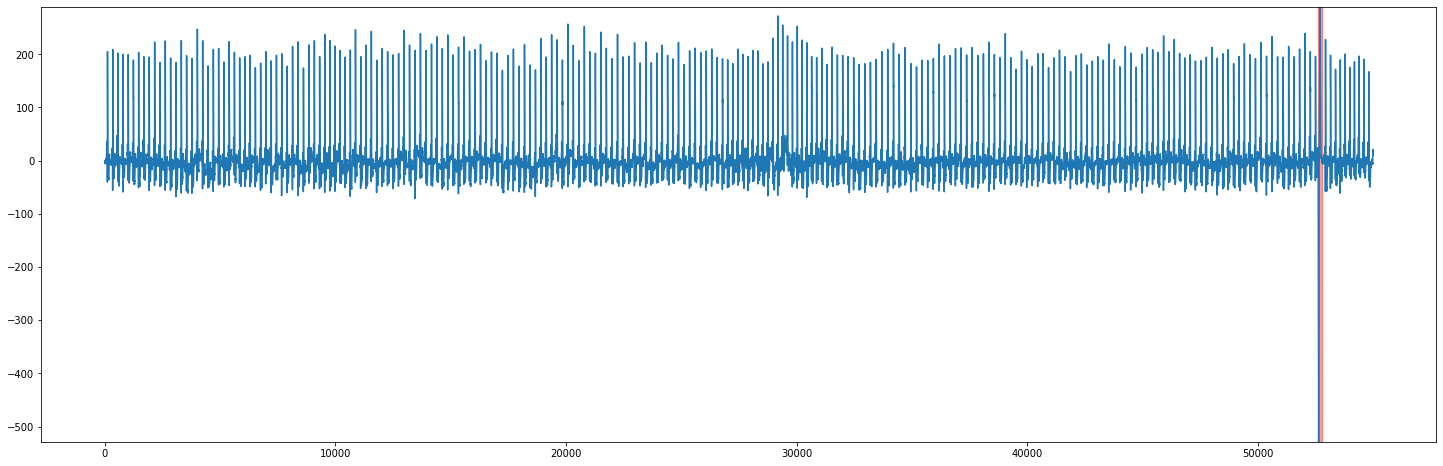

In [4]:
ds.plot()

In [5]:
ds.ts_scaled[:int(len(ds.ts)*0.4)].shape

(22000, 1)

In [8]:
TIME_STEPS = 115*4

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(ds.ts_scaled[:int(len(ds.ts)*0.4)], TIME_STEPS)
print("Training input shape: ", x_train.shape)

Training input shape:  (21541, 460, 1)


In [9]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 230, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 230, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 115, 16)           3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 230, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 230, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 460, 32)          3616      
 ranspose)                                            

In [11]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    workers=-1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
606/606 [==============================] - 12s 19ms/step - loss: 9.8670e-04 - val_loss: 9.0959e-04
Epoch 2/50
606/606 [==============================] - 12s 19ms/step - loss: 2.0839e-04 - val_loss: 2.1546e-04
Epoch 3/50
606/606 [==============================] - 13s 22ms/step - loss: 1.3182e-04 - val_loss: 1.8935e-04
Epoch 4/50
606/606 [==============================] - 16s 26ms/step - loss: 1.0625e-04 - val_loss: 1.7730e-04
Epoch 5/50
606/606 [==============================] - 12s 20ms/step - loss: 8.6507e-05 - val_loss: 1.1805e-04
Epoch 6/50
606/606 [==============================] - 14s 23ms/step - loss: 7.4933e-05 - val_loss: 2.3005e-04
Epoch 7/50
606/606 [==============================] - 12s 20ms/step - loss: 6.4130e-05 - val_loss: 1.6017e-04
Epoch 8/50
606/606 [==============================] - 12s 19ms/step - loss: 5.7278e-05 - val_loss: 1.9673e-04
Epoch 9/50
606/606 [==============================] - 12s 20ms/step - loss: 5.1899e-05 - val_loss: 2.1096e-04
Epoch 10/5

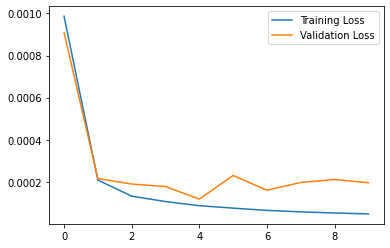

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

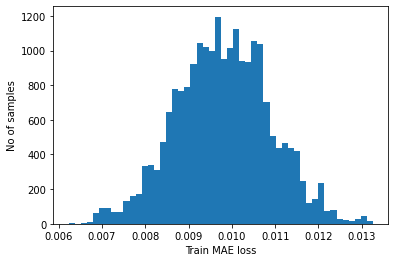

Reconstruction error threshold:  0.001


In [20]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = 0.001
print("Reconstruction error threshold: ", threshold)

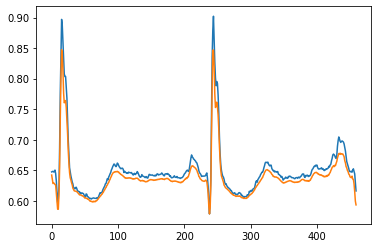

In [21]:
plt.plot(x_train[100])
plt.plot(x_train_pred[100])
plt.show()

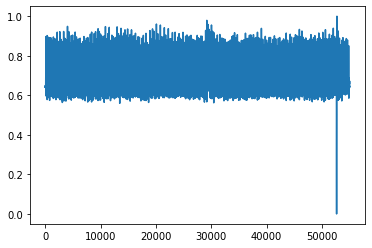

Test input shape:  (54541, 460, 1)


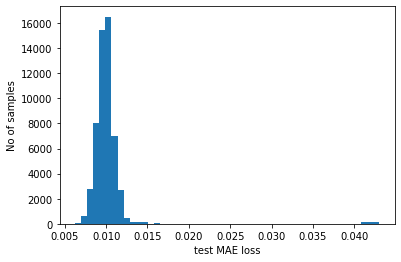

Number of anomaly samples:  471
Indices of anomaly samples:  (array([52175, 52176, 52177, 52178, 52179, 52180, 52181, 52182, 52183,
       52184, 52185, 52186, 52187, 52188, 52189, 52190, 52191, 52192,
       52193, 52194, 52195, 52196, 52197, 52198, 52199, 52200, 52201,
       52202, 52203, 52204, 52205, 52206, 52207, 52208, 52209, 52210,
       52211, 52212, 52213, 52214, 52215, 52216, 52217, 52218, 52219,
       52220, 52221, 52222, 52223, 52224, 52225, 52226, 52227, 52228,
       52229, 52230, 52231, 52232, 52233, 52234, 52235, 52236, 52237,
       52238, 52239, 52240, 52241, 52242, 52243, 52244, 52245, 52246,
       52247, 52248, 52249, 52250, 52251, 52252, 52253, 52254, 52255,
       52256, 52257, 52258, 52259, 52260, 52261, 52262, 52263, 52264,
       52265, 52266, 52267, 52268, 52269, 52270, 52271, 52272, 52273,
       52274, 52275, 52276, 52277, 52278, 52279, 52280, 52281, 52282,
       52283, 52284, 52285, 52286, 52287, 52288, 52289, 52290, 52291,
       52292, 52293, 52294, 

In [28]:
df_test_value = ds.ts_scaled
fig, ax = plt.subplots()
plt.plot(df_test_value)
plt.show()

# Create sequences from test values.
x_test = create_sequences(ds.ts_scaled)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > 0.02
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [26]:
anomalies = test_mae_loss > 0.03
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  453
Indices of anomaly samples:  (array([52184, 52185, 52186, 52187, 52188, 52189, 52190, 52191, 52192,
       52193, 52194, 52195, 52196, 52197, 52198, 52199, 52200, 52201,
       52202, 52203, 52204, 52205, 52206, 52207, 52208, 52209, 52210,
       52211, 52212, 52213, 52214, 52215, 52216, 52217, 52218, 52219,
       52220, 52221, 52222, 52223, 52224, 52225, 52226, 52227, 52228,
       52229, 52230, 52231, 52232, 52233, 52234, 52235, 52236, 52237,
       52238, 52239, 52240, 52241, 52242, 52243, 52244, 52245, 52246,
       52247, 52248, 52249, 52250, 52251, 52252, 52253, 52254, 52255,
       52256, 52257, 52258, 52259, 52260, 52261, 52262, 52263, 52264,
       52265, 52266, 52267, 52268, 52269, 52270, 52271, 52272, 52273,
       52274, 52275, 52276, 52277, 52278, 52279, 52280, 52281, 52282,
       52283, 52284, 52285, 52286, 52287, 52288, 52289, 52290, 52291,
       52292, 52293, 52294, 52295, 52296, 52297, 52298, 52299, 52300,
       52301, 52302, 52303, 

In [24]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

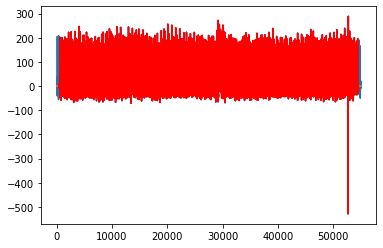

In [25]:
df_subset = ds.df.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
ds.df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [19]:
df_subset.plot(legend=False, ax=ax, color="r")

<AxesSubplot:>